In [1]:
import LibsControl
import numpy
import matplotlib.pyplot as plt


#load dynamics from log file
def load_from_file(file_name):
    v = numpy.loadtxt(file_name)

    u = numpy.array(v[:, 1:3])
    x = numpy.array(v[:, 3:5])

    dt= v[:, -1].mean()*0.001
    t = numpy.arange(x.shape[0])*dt
    
    return u, x, t, dt

def difference(x):
    #add velocity terms
    x_pad = numpy.zeros((1, x.shape[1]))
    x_tmp = numpy.concatenate([x_pad, x], axis=0)

    #estimate velocity term
    dx = x_tmp[1:, :]  - x_tmp[0:-1, :]

    return dx

def state_augmentation(x, wheel_diameter = 34.0):
    #wheel angular position to distance (rad to mm)
    x_aug = 0.5*wheel_diameter*x
    
    #zero initial conditions
    x_aug = x_aug - x_aug[0]
    
    #add velocity term
    vel = difference(x_aug[:, 0:2])
    x_aug = numpy.concatenate([x_aug, vel], axis=1)


    return x_aug



def plot_results(t_result, u_result, x_ref, x_pred, steps_start = 0 , steps_end = -1):

    plt.clf()
    
    fig, axs = plt.subplots(4, 1, figsize=(8, 2*5))


    axs[0].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 0], color="purple")
    axs[0].set_xlabel("time [s]")
    axs[0].set_ylabel("control left")
    axs[0].grid()

    axs[1].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 1], color="purple")
    axs[1].set_xlabel("time [s]")
    axs[1].set_ylabel("control right")
    axs[1].grid()


    axs[2].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 0], label="ground truth", color="red")
    axs[2].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 0], label="prediction", color="blue")
    axs[2].set_xlabel("time [s]")
    axs[2].set_ylabel("distance left [mm]")
    axs[2].legend()
    axs[2].grid()

    axs[3].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 1], color="red")
    axs[3].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 1], color="blue")
    axs[3].set_xlabel("time [s]")
    axs[3].set_ylabel("distance right [mm]")
    axs[3].grid()

    

    #fig.legend()


def matrix_to_c(name, x, eps = 10**-10):

    x_tmp = x.copy()

    x_tmp[numpy.where(numpy.abs(x_tmp) < eps)] = 0.0

    result_str = ""

    result_str+= "float " + name + "[] = {\n"
    for m in range(x.shape[0]):
        result_str+= "\t\t"
        for n in range(x.shape[1]):
            result_str+= str(numpy.float32(x_tmp[m][n]))
            if m == x.shape[0]-1 and n == x.shape[1]-1:
                result_str+= " "
            else:
                result_str+= ", "
       
        if m != x.shape[0]-1:
            result_str+= "\n"

    result_str+= "};\n"

    return result_str


In [2]:
#obtain response
u_result, x_result, t_result, dt = load_from_file("./data/run_4.log")

max_rpm_speed = 1200
 

#u_result = u_result/((max_rpm_speed/60.0)*numpy.pi)

x_ref = state_augmentation(x_result)



#identification
a_est, b_est = LibsControl.recursive_ls_identification(u_result, x_ref)
    
c_est = numpy.zeros((a_est.shape[0]//2, a_est.shape[0]))
for n in range(a_est.shape[0]//2):
    c_est[n][n] = 1.0


print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")
print("mat_c = \n", c_est, "\n\n")




#model symmetrization

x_flip = numpy.flip(x_result.copy(), axis=1)
u_flip = numpy.flip(u_result.copy(), axis=1)

x_flip = state_augmentation(x_flip)

#identification
a_est_flip, b_est_flip = LibsControl.recursive_ls_identification(u_flip, x_flip)

print("mat_a_flip = \n", a_est_flip, "\n\n")
print("mat_b_flip = \n", b_est_flip, "\n\n")

#one model rule them all
a_est = (a_est + a_est_flip)/2
b_est = (b_est + b_est_flip)/2



print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")


n_steps  = u_result.shape[0]
n_inputs = u_result.shape[1]
n_states = x_ref.shape[1]


mat_a = 
 [[ 1.00030946e+00 -9.38568220e-05 -1.17832085e-01  3.56992425e-02]
 [-1.57703750e-04  1.00033056e+00  1.00894514e-01 -2.99919844e-03]
 [ 3.09457624e-04 -9.38568219e-05 -1.17832084e-01  3.56992425e-02]
 [-1.57703750e-04  3.30561173e-04  1.00894514e-01 -2.99919817e-03]] 


mat_b = 
 [[ 0.07774345 -0.00162543]
 [-0.00672227  0.06948488]
 [ 0.07774345 -0.00162543]
 [-0.00672227  0.06948488]] 


mat_c = 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]] 


mat_a_flip = 
 [[ 1.00033056e+00 -1.57703750e-04 -2.99919844e-03  1.00894514e-01]
 [-9.38568220e-05  1.00030946e+00  3.56992425e-02 -1.17832085e-01]
 [ 3.30561173e-04 -1.57703750e-04 -2.99919817e-03  1.00894514e-01]
 [-9.38568219e-05  3.09457624e-04  3.56992425e-02 -1.17832084e-01]] 


mat_b_flip = 
 [[ 0.06948488 -0.00672227]
 [-0.00162543  0.07774345]
 [ 0.06948488 -0.00672227]
 [-0.00162543  0.07774345]] 


mat_a = 
 [[ 1.00032001e+00 -1.25780286e-04 -6.04156417e-02  6.82968783e-02]
 [-1.25780286e-04  1.00032001e+00  6.82968783e-02 -6.04156417

<Figure size 640x480 with 0 Axes>

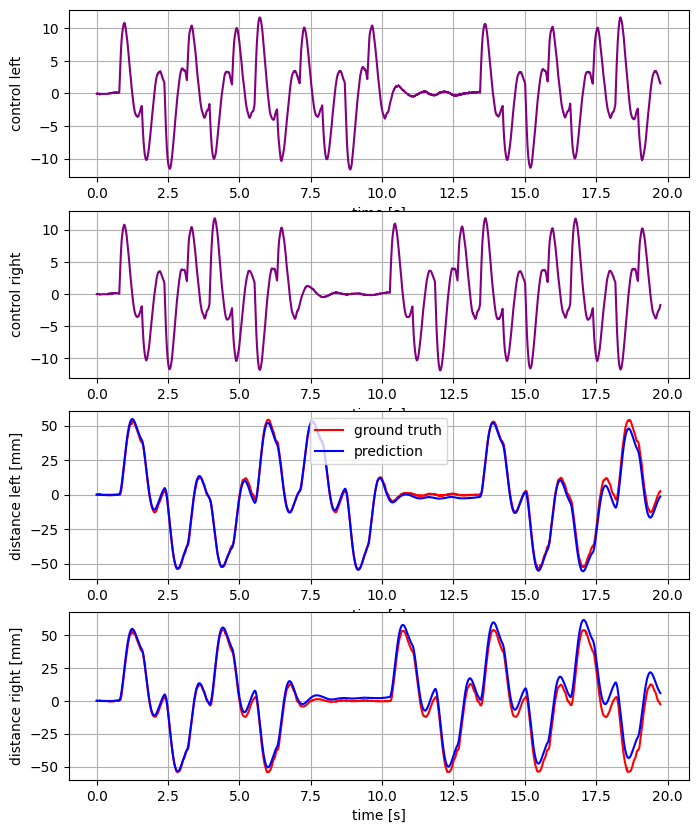

In [3]:
#model verification
#set same inputs and initial conditions

ds = LibsControl.DynamicalSystemDiscrete(a_est, b_est, None)    

x_initial = numpy.expand_dims(x_ref[0], axis=0).T
ds.reset(x_initial)

x_hat_result = []

for n in range(n_steps):

    u = u_result[n, :]
    u = numpy.expand_dims(u, axis=0).T

    x, y = ds.forward_state(u)

    x_hat_result.append(x[:, 0])

x_hat_result = numpy.array(x_hat_result)

#plot results
plot_results(t_result, u_result, x_ref, x_hat_result, 0, 5000)


In [4]:
#controller synthetis

#create loss weighting matrices (diagonal)
q = numpy.diag([ 1.0, 1.0, 0.0, 0.0] )
r = numpy.diag( [10000.0, 10000.0]) 

#1400rpm max
antiwindup = (50000/60.0)*2.0*numpy.pi

#solve LQR controller
lqr = LibsControl.LQRDiscrete(a_est, b_est, q, r, antiwindup)

print("controller")
print("k  = \n", lqr.k, "\n")
print("ki = \n", lqr.ki, "\n")
print("\n\n")

print("poles OL = ", numpy.linalg.eigvals(a_est))
print("poles CL = ", numpy.linalg.eigvals(a_est - b_est@lqr.k))



controller
k  = 
 [[ 0.55063263 -0.00297259 -0.02890544  0.03317353]
 [-0.00297259  0.55063263  0.03317353 -0.02890544]] 

ki = 
 [[1.01896048e-02 2.23792813e-07 0.00000000e+00 0.00000000e+00]
 [2.23792832e-07 1.01896048e-02 0.00000000e+00 0.00000000e+00]] 




poles OL =  [ 1.00039497  1.00019577 -0.1286617   0.00787969]
poles CL =  [-0.12874453  0.00788559  0.96186382  0.96224295]


<Figure size 640x480 with 0 Axes>

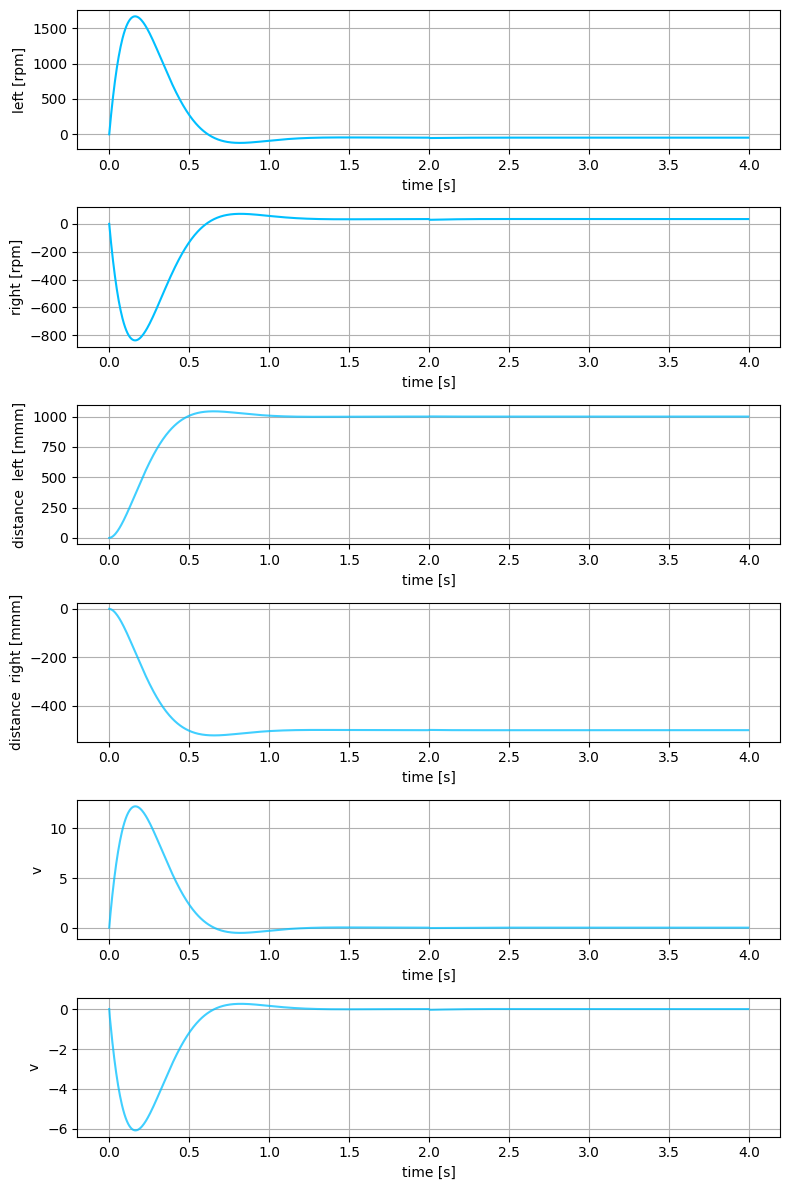

In [5]:
#process simulation

n_max = int(4.0/dt)

#required output, 1m, -0.5m
xr = numpy.array([[1000.0, -500, 0.0, 0.0]]).T

#plant state
x     = numpy.zeros((a_est.shape[0], 1))

#initial error integral
integral_action = numpy.zeros((b_est.shape[1], 1))

#result log
t_result = [] 
u_result = []
x_result = []
int_result = []



for n in range(n_max):

    #compute controller output
    u, integral_action = lqr.forward(xr, x, integral_action)

    #disturbance
    '''
    if n > n_max//2:
        u[0, :]+= 50
        u[1, :]+= 100
    '''

    if n == n_max//2:
        x[0, 0]+= 1 
        x[1, 0]+= 1
    
    #compute plant output
    y = c_est@x
    x = a_est@x + b_est@u
    
    t_result.append(n*dt)
    u_result.append(u[:, 0].copy())
    x_result.append(x[:, 0].copy())

    int_result.append(integral_action[:, 0].copy())
    
    
t_result = numpy.array(t_result)
u_result = numpy.array(u_result)
x_result = numpy.array(x_result)

int_result = numpy.array(int_result)


u_result*= 60.0*1.0/(2.0*numpy.pi)

#plot results
#convert angle to degrees
LibsControl.plot_closed_loop_response(t_result, u_result, x_result, x_hat = None, file_name = "lqr_discrete_output.png", u_labels = ["left [rpm]", "right [rpm]"], x_labels = ["distance  left [mmm]", "distance  right [mmm]", "v", "v"])




In [6]:
#print c-like arrays
print(matrix_to_c("k", lqr.k))
print(matrix_to_c("ki", lqr.ki))


float k[] = {
		0.55063266, -0.0029725889, -0.02890544, 0.033173535, 
		-0.0029725889, 0.55063266, 0.033173535, -0.02890544 };

float ki[] = {
		0.010189605, 2.2379281e-07, 0.0, 0.0, 
		2.2379284e-07, 0.010189605, 0.0, 0.0 };

